**Rio de Janeiro**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from statistics import mean

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [3]:
city = 'Rio de Janeiro'
words = ['rio de janeiro','cidade maravilhosa','carioca','fluminense','prefeito','governador','prefeitura','crivella','witzel']
df = pd.DataFrame.from_records(collection.find({'lang': {'$ne':'und'}, 'text': re.compile('|'.join(words), re.IGNORECASE),'city':city,'score': {'$ne':None}, 'polarity': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'polarity':1,'_id': 0}).sort('created_at'))
#df = pd.DataFrame.from_records(collection.find({'lang': {'$ne':'und'}, 'city':city,'score': {'$ne':None}, 'polarity': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'polarity':1,'_id': 0}).sort('created_at'))

In [4]:
len(df)

1503

In [5]:
df.to_excel(city+'.xlsx')

In [6]:
df.head()

,created_at,geo_source,state,city,text,score,lang,polarity
0,2020-02-03 17:43:00,user_location,Rio de Janeiro,Rio de Janeiro,Mais de 17 mil pessoas já foram infectadas na ...,-0.6705,pt,-0.108429
1,2020-02-04 11:17:44,user_location,Rio de Janeiro,Rio de Janeiro,@CedaeRJ Se nossos governador não tem capacida...,-0.4753,pt,0.065889
2,2020-02-04 23:50:10,user_location,Rio de Janeiro,Rio de Janeiro,Ah esses cariocas com medo do coronavirus... p...,-0.6571,pt,-0.236000
3,2020-02-05 00:42:59,user_location,Rio de Janeiro,Rio de Janeiro,"Carioca é ""imorrível""! Sobrevive a tudo de rui...",-0.5848,pt,0.225667
4,2020-02-05 18:12:59,place,Rio de Janeiro,Rio de Janeiro,"@andrizek É André essa é nossa dura realidade,...",0.7922,pt,0.250308


Média total de sentimentos - Vader

In [7]:
df['score'].describe()

count    1503.000000
mean       -0.126345
std         0.445276
min        -0.984000
25%        -0.476700
50%        -0.095100
75%         0.128000
max         0.989600
Name: score, dtype: float64

Média total de sentimentos - SenticNet

In [8]:
df['polarity'].describe()

count    1503.000000
mean        0.161703
std         0.230776
min        -0.815000
25%         0.011100
50%         0.178933
75%         0.328000
max         0.907500
Name: polarity, dtype: float64

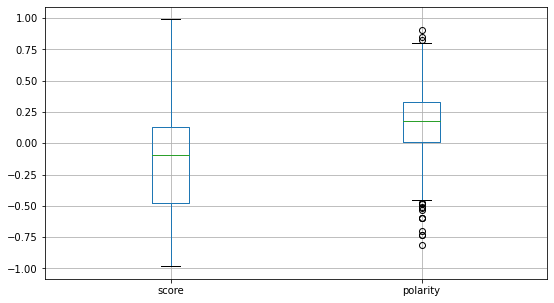

In [9]:
boxplot = df.boxplot(column=['score', 'polarity'], grid=True, figsize=(9, 5))

In [10]:
# Calculando coeficiente de correlação entre score e polarity (método de Pearson)
df['score'].corr(df['polarity'])

0.2797557945126904

Funções auxiliares

In [11]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, column):

    date_set = set()  
    
    for item in df.created_at:
        date = datetime.datetime(item.year, item.month, item.day)
        date_set.add(date)
    
    # Listas utilizadas para montagem do df
    date_list = list(date_set)
    date_list.sort()
    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        # Média de scores do período
        score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
        score_mean_list.append(score_mean)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [12]:
# Função para geração de gráficos
def generate_graphic(x, y, label, color, xLabel, yLabel, title):
         
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [13]:
# Função para gerar um gráfico X outro
def generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title):
      
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y1,color=color1, linestyle='solid', linewidth=2,label=label1)
    plt.plot(x,y2,color=color2, linestyle='solid', linewidth=2,label=label2)

    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [14]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Média de sentimentos por dia - Vader x SenticNet

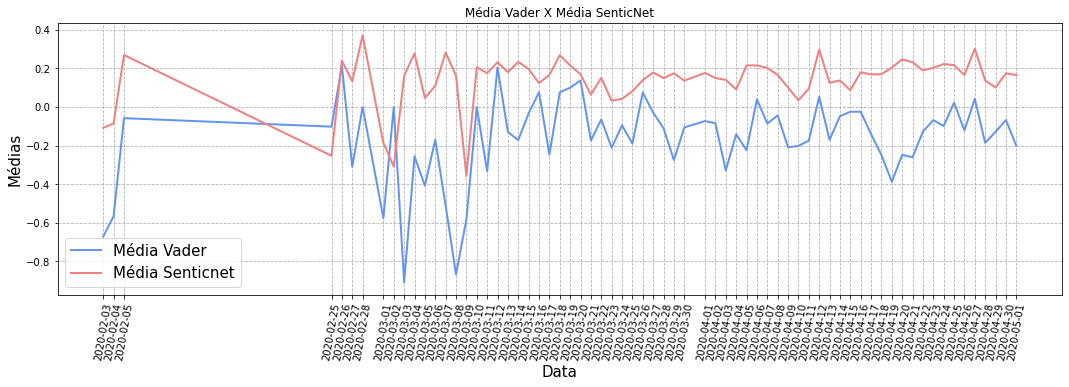

In [15]:
df1 = building_dates_df(df, 'score')
df2 = building_dates_df(df, 'polarity')

x = df1.created_at
y1 = df1.score_mean
y2 = df2.polarity_mean

label1 = 'Média Vader'
label2 = 'Média Senticnet'

color1 = 'cornflowerblue'
color2 = 'lightcoral'

xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader X Média SenticNet'

generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title)

Análises por período

In [16]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [17]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "'+city+'"')
df_cases_city = df_cases_city.reset_index()
df_cases_city.head()

,index,city,date,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths
0,25,Rio de Janeiro,2020-03-06,1,0.01482,0.0,0,RJ,1,0
1,34,Rio de Janeiro,2020-03-07,1,0.01482,0.0,0,RJ,0,0
2,47,Rio de Janeiro,2020-03-08,2,0.02964,0.0,0,RJ,1,0
3,62,Rio de Janeiro,2020-03-09,2,0.02964,0.0,0,RJ,0,0
4,77,Rio de Janeiro,2020-03-10,2,0.02964,0.0,0,RJ,0,0


In [18]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

2020-03-06


In [19]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

2020-03-23


Datas relevantes:

- Data do primeiro caso: 06/03/2020
- Data da primeira morte: 23/03/2020


- Data do primeiro decreto de medidas restritivas (Governador): 17/03/2020 a 29/03/2020
- Data da segundo decreto de medidas restritivas (Governador): 30/03/2020 a 12/04/2020
- Data da terceiro decreto de medidas restritivas (Governador): 13/04/2020 a 29/04/2020
- Data da quarto decreto de medidas restritivas(Governador): 30/04/2020 a 01/05/2020

**Análises - Datas de medidas restritivas - Antes e Depois a Primeira Medida**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 16/03/2020)**

In [20]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-16 23:59:59"')
len(df1_periodo1)

137

**Média de sentimentos no segundo intervalo (17/03/2020 a 30/04/2020)**

In [21]:
df1_periodo2 = df.query('created_at >= "2020-03-17 00:00:00" and created_at <= "2020-04-30 23:59:59"')
len(df1_periodo2)

1324

Gráfico - Média Valores

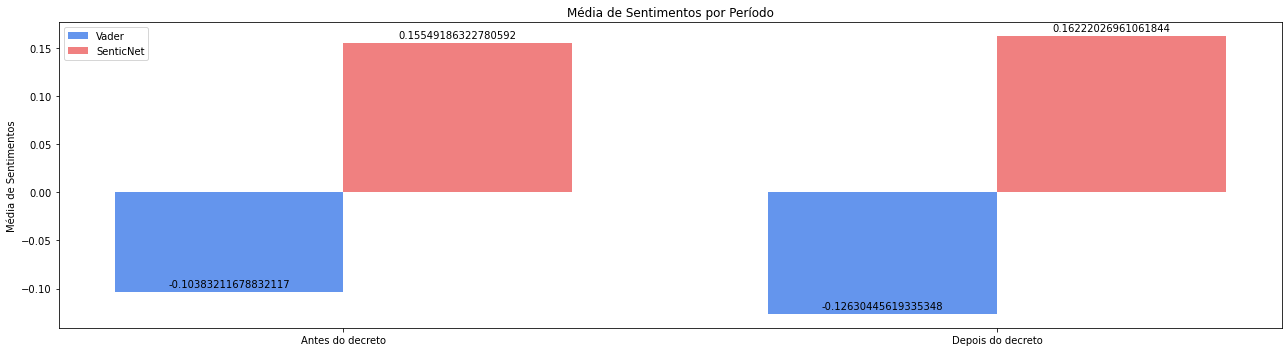

In [22]:
labels = ['Antes do decreto', 'Depois do decreto']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score'])]
y2 = [mean(df1_periodo1['polarity']), mean(df1_periodo2['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Análises - Datas de medidas restritivas - Por períodos de decretos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 16/03/2020)**

In [23]:
df1_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-16 23:59:59"')
len(df1_periodo1)

137

**Média de sentimentos no segundo intervalo (17/03/2020 a 29/03/2020)**

In [24]:
df1_periodo2 = df.query('created_at >= "2020-03-17 00:00:00" and created_at <= "2020-03-29 23:59:59"')
len(df1_periodo2)

240

**Média de sentimentos no terceiro intervalo (30/03/2020 a 12/04/2020)**

In [25]:
df1_periodo3 = df.query('created_at >= "2020-03-30 00:00:00" and created_at <= "2020-04-12 23:59:59"')
len(df1_periodo3)

269

**Média de sentimentos no quarto intervalo (13/04/2020 a 29/04/2020)**

In [26]:
df1_periodo4 = df.query('created_at >= "2020-04-13 00:00:00" and created_at <= "2020-04-29 23:59:59"')
len(df1_periodo4)

778

**Média de sentimentos no quarto intervalo (30/04/2020 a 01/05/2020)**

In [27]:
df1_periodo5 = df.query('created_at >= "2020-04-30 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df1_periodo5)

79

Gráfico - Média Valores

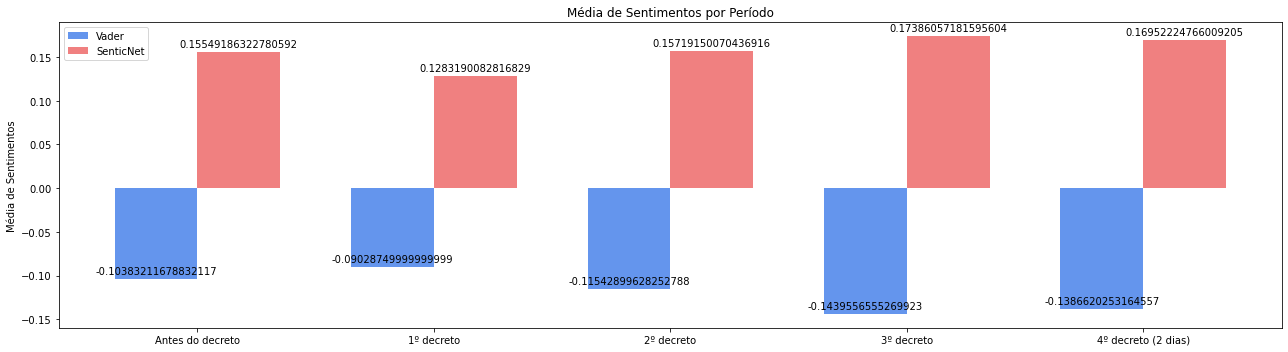

In [28]:
labels = ['Antes do decreto', '1º decreto', '2º decreto', '3º decreto','4º decreto (2 dias)']
y1 = [mean(df1_periodo1['score']), mean(df1_periodo2['score']), mean(df1_periodo3['score']), mean(df1_periodo4['score']), mean(df1_periodo5['score'])]
y2 = [mean(df1_periodo1['polarity']), mean(df1_periodo2['polarity']), mean(df1_periodo3['polarity']), mean(df1_periodo4['polarity']), mean(df1_periodo5['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

**Análises - Marcos relevantes de casos**

**Média de sentimentos no primeiro intervalo (01/02/2020 a 05/03/2020)**

In [29]:
df2_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-05 23:59:59"')
len(df2_periodo1)

26

**Média de sentimentos no segundo intervalo (06/02/2020 a 22/03/2020)**

In [30]:
df2_periodo2 = df.query('created_at >= "2020-02-06 00:00:00" and created_at <= "2020-03-22 23:59:59"')
len(df2_periodo2)

235

**Média de sentimentos no terceiro intervalo (23/03/2020 a 01/05/2020)**

In [31]:
df2_periodo3 = df.query('created_at >= "2020-03-23 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df2_periodo3)

1262

Gráfico

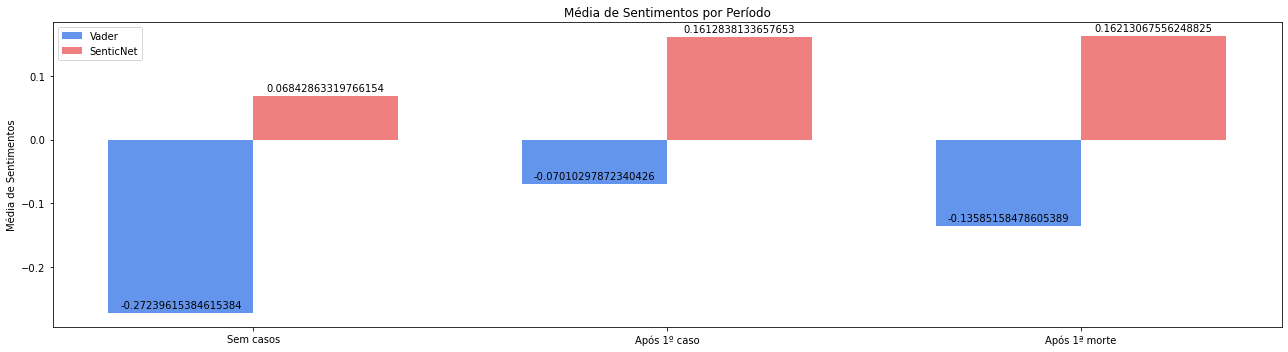

In [32]:
labels = ['Sem casos', 'Após 1º caso', 'Após 1ª morte']
y1 = [mean(df2_periodo1['score']), mean(df2_periodo2['score']), mean(df2_periodo3['score'])]
y2 = [mean(df2_periodo1['polarity']), mean(df2_periodo2['polarity']), mean(df2_periodo3['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Fontes:
- Confira as medidas do decreto do governo do RJ para conter o coronavírus - https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/17/confira-as-medidas-do-decreto-do-governo-do-rj-para-conter-o-coronavirus.ghtml
- Witzel renova medidas restritivas contra o coronavírus no RJ por mais 15 dias - https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/30/witzel-assina-decreto-nesta-segunda-renovando-medidas-restritivas-contra-o-coronavirus-no-rj-por-mais-15-dias.ghtml
- Coronavírus: Witzel prorroga até 30 de abril medidas restritivas no Rio: https://valorinveste.globo.com/mercados/brasil-e-politica/noticia/2020/04/13/coronavrus-witzel-prorroga-at-30-de-abril-medidas-restritivas-no-rio.ghtml